# Data Preprocessing

RawData -> (trainloader, testloader)

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function and optimizer
4. Train the network on the training data
5. Test the network on the test data

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from collections import Counter 
import utils
import importlib ## debug while producing utils
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


importlib.reload(utils)
torch.multiprocessing.set_sharing_strategy('file_system')

In [6]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(device)

CUDA is not available.  Training on CPU ...
cpu


1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
   
The output of [torchvision datasets](https://pytorch.org/vision/stable/datasets.html#datasets) are PILImage images of range [0, 1].
We [transform](https://pytorch.org/vision/stable/transforms.html) them to Tensors of normalized range [-1, 1]. Then we call the [dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)



In [7]:
transform = transforms.Compose([
    # convert PIL images to Pytorch tensors
    transforms.ToTensor(),
    #normalize pixel values (here for channel mean=0.5 std=0.5)
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.220, 0.224, 0.225])
])

In [8]:
# Define the targets airplane (0), automobile (1), and bird (2)
# target_classes = [0, 1, 2]

In [9]:
trainset = torchvision.datasets.CIFAR10(root='./data', 
                                              train=True, 
                                              download=True, 
                                              transform=transform)

# trainset = utils.FilteredCIFAR10(trainset, target_classes)

Files already downloaded and verified


In [10]:
trainloader = torch.utils.data.DataLoader(trainset,
                                         batch_size = 4,
                                         shuffle = True,
                                         num_workers = 2)

In [11]:
testset = torchvision.datasets.CIFAR10(root='./data', 
                                              train=False, 
                                              download=True, 
                                              transform=transform)

# testset = utils.FilteredCIFAR10(testset, target_classes)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size = 4,
                                         shuffle = True,
                                         num_workers = 2)

Files already downloaded and verified


In [12]:
# classes = ["plane", "car", "bird"]#, "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Let us [show](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib-pyplot-imshow) some of the training images


Train loader:
12500
{'frog': 5000, 'truck': 5000, 'deer': 5000, 'car': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'plane': 5000}
torch.Size([4, 3, 32, 32])
dog deer bird frog

Test loader:
2500
{'cat': 1000, 'ship': 1000, 'plane': 1000, 'frog': 1000, 'car': 1000, 'truck': 1000, 'dog': 1000, 'horse': 1000, 'deer': 1000, 'bird': 1000}


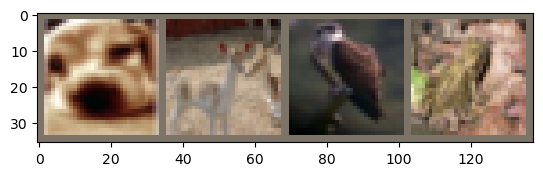

In [13]:
# Function to display an image
def imshow(image):
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])

    # Unnormalize the image channels to [0, 1]
    image = image.mul(std.unsqueeze(1).unsqueeze(2))  # More efficient element-wise multiplication
    image = image.add(mean.unsqueeze(1).unsqueeze(2))  # Efficient element-wise addition

    image= image.clamp(0, 1)

    # Convert the tensor to a NumPy array
    npimg = image.numpy()
    # Plot the image using matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose for correct display

# ------------------ Train Loader Section ------------------

print("Train loader:")

# Count the frequency of each class in the training set
stat = dict(Counter(trainset.targets))

# Create a new dictionary with class names as keys
new_stat = stat.copy()
for k in stat.keys():
    new_stat[classes[k]] = stat[k]
    del new_stat[k]

# Print the length of the train loader (number of batches)
print(len(trainloader))

# Print the class distribution in the training set
print(new_stat)

# Get a batch of random training images and their labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Print the shape of the image tensor (batch_size, channels, height, width)
print(images.shape)

# Display the images using the imshow function
imshow(torchvision.utils.make_grid(images))

# Print the labels of the images
print(' '.join('%s' % classes[labels[j]] for j in range(4)))  # Print labels for 4 images

# ------------------ Test Loader Section ------------------

print("\nTest loader:")



# Similar steps for the test loader
stat = dict(Counter(testset.targets))
new_stat = stat.copy()
for k in stat.keys():
    new_stat[classes[k]] = stat[k]
    del new_stat[k]

print(len(testloader))
print(new_stat)

# Model: Convolution Neural Network
[network layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() 
        self.conv1 = nn.Conv2d(3, 6, 5)  # First convolutional layer
        self.conv2 = nn.Conv2d(6, 16, 5)  # Second convolutional layer
        # pool
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) ## set nim ogf classes now

    def forward(self, x):
        """Define the forward pass of the network"""
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.shape[0], -1)  # Flatten the output from convolutional layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
       

In [14]:
import torch.nn.functional as F
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # 64 filters, 8x8 feature maps size after pooling
        self.fc2 = nn.Linear(512, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        # Forward pass through convolutional layers with ReLU and pooling
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout2(x)

        # Flattening the layer
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor for the fully connected layer

        # Fully connected layer with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)  # Output layer, no activation function here
        
        return F.log_softmax(x, dim=1)  # Applying softmax to get probabilities

In [17]:
# Typically, define the loss and optimizer outside of your network class
net = Net()
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(net.parameters(), lr=0.002)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)  
# Reduces the learning rate by a factor of 0.1 every step_size epochs, i need to step it every epoch


## Receptive Field of the network (does not work with dropout layers so donmt run with them)

In [ ]:
# This line attempts to clone a Git repository using a shell command.
#!git clone https://github.com/Fangyh09/pytorch-receptive-field.git

# This line would move the downloaded directory
#!mv -v pytorch-receptive-field/torch_receptive_field ./

# Import the 'receptive_field' function from the 'torch_receptive_field' library.
from torch_receptive_field import receptive_field

# Calculate the receptive field of the network 'net' for an input image size of
# 3 channels (RGB) and 32x32 pixels. The 'receptive_field' function would analyze the network architecture and input size to determine
# the receptive field size for each layer and the overall network.
receptive_field(net, input_size=(3, 32, 32))

3. Define a loss function and optimizer

Let's use a Classification [Cross-Entropy](https://pytorch.org/docs/stable/nn.html#loss-functions) loss and [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) with momentum.



4. Train the network on the training data


We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



# Training Phase

In [18]:
def evaluate_model(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    # print('Test Loss: {:.4f}, Accuracy: {:.4f}'.format(avg_loss, accuracy))
    return(avg_loss, accuracy)

# Assuming test_loader is defined and contains your test dataset
evaluate_model(net, testloader, criterion)

(2.3022101908683776, 0.1295)

In [19]:
## Training 
patience = 2
useless_epochs = 0

best_model = None
test_losses = []
test_accuracies = []
running_losses = []

# Ensure all required modules and data are loaded (trainloader, net, optimizer, criterion, device)
for epoch in range(15):
    
    if patience is not None and useless_epochs >= patience:
        print(f"Training stopped: No improvement in test loss for {patience} epochs.")
        break
        
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 0 and i > 0:
            print(f'[{epoch + 1}, {i}] loss: {running_loss / 1000:.3f}')
            running_losses.append(running_loss / 1000)
            running_loss = 0.0

    test_loss, test_accuracy = evaluate_model(net, testloader, criterion)
    if best_model is None or test_loss < min(test_losses):
        best_model = net
        torch.save(best_model.state_dict(), 'best_model.pth')
        print(f"Best model updated at epoch {epoch + 1}")
        useless_epochs = 0
    else:
        useless_epochs += 1
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    scheduler.step()
    print(f"Epoch {epoch + 1}: Test loss = {test_loss:.2f}, accuracy = {test_accuracy:.2%}")
    

train_epoch_losses = running_losses[::len(trainloader) // 1000]  # Adjust this based on your actual logging frequency
print('Finished Training')


[1, 1000] loss: 1.959
[1, 2000] loss: 1.656
[1, 3000] loss: 1.522
[1, 4000] loss: 1.430
[1, 5000] loss: 1.290
[1, 6000] loss: 1.303
[1, 7000] loss: 1.218
[1, 8000] loss: 1.190
[1, 9000] loss: 1.167
[1, 10000] loss: 1.121
[1, 11000] loss: 1.148
[1, 12000] loss: 1.098
Best model updated at epoch 1
Epoch 1: Test loss = 1.08, accuracy = 61.76%
[2, 1000] loss: 1.007
[2, 2000] loss: 0.991
[2, 3000] loss: 0.976
[2, 4000] loss: 0.970
[2, 5000] loss: 1.002
[2, 6000] loss: 0.958
[2, 7000] loss: 0.954
[2, 8000] loss: 0.972
[2, 9000] loss: 0.973
[2, 10000] loss: 0.968
[2, 11000] loss: 0.935
[2, 12000] loss: 0.969
Epoch 2: Test loss = 0.99, accuracy = 65.41%
[3, 1000] loss: 0.722
[3, 2000] loss: 0.671
[3, 3000] loss: 0.656
[3, 4000] loss: 0.633
[3, 5000] loss: 0.614
[3, 6000] loss: 0.631
[3, 7000] loss: 0.617
[3, 8000] loss: 0.591
[3, 9000] loss: 0.627
[3, 10000] loss: 0.618
[3, 11000] loss: 0.616
[3, 12000] loss: 0.623
Epoch 3: Test loss = 0.86, accuracy = 71.06%
Training stopped: No improvement i

5. Test the network on the test data


We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.




In [20]:
# Initialize variables to track accuracy
correct = 0
total = 0

# Disable gradient calculation for better performance during evaluation
with torch.no_grad():
    # Loop over the test loader
    for data in testloader:
        # Get the image and label from the current batch
        image, label = data

        # Move the image data to the specified device (CPU or GPU)
        image = image.to(device)

        # Get the network's prediction for the image
        output = net(image)
        # smax = torch.nn.Softmax(dim=1)(output.cpu())
        
        # Find the class with the highest probability
        _, predicted = torch.max(output.cpu(), 1)  # Equivalent to pred = torch.argmax(output.cpu(), dim=1)

        # Update total number of test images
        total += label.size(0)  # label.size(0) gives the batch size

        # Count correct predictions
        correct += (predicted == label).sum().item()  # Count true positives

# Calculate and print accuracy
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 71 %


**!HOMEWORK!**

This homework assignment asks you to performs 2 tasks:

1. Analyze Results with Different Network Parameters:

This involves training the network with various configurations of network parameters and analyzing the impact on performance. Here's a step-by-step approach:

**Choose Network Parameters:**

Select the network parameters you want to experiment with. Common choices include:

Number of layers: You can try increasing or decreasing the number of layers in your chosen network architecture (e.g., convolutional layers in a CNN).
Learning rate: Experiment with different learning rates (e.g., 0.01, 0.001, 0.0001) to find a balance between fast learning and stability.
Other parameters: Depending on your network architecture, there might be additional options like:
Number of filters in convolutional layers: This affects the complexity of features extracted from the data.
Activation functions: Experiment with different activation functions (e.g., ReLU, Leaky ReLU) to introduce non-linearity.
Optimizer parameters: Some optimizers (e.g., Adam) have hyperparameters you can adjust.
Train the network for a different number of epochs.

**Analyze Results:**

Compare the performance of the network across different parameter configurations:

How accuracy/loss changes with different parameter values.
2. Show and Explain Errors of the Best Network:

Once you identify the **best performing network configuration** (based on metrics like accuracy or loss), analyze its errors.
For example you can generate a confusion matrix. This matrix visualizes how often the network predicted each class correctly or incorrectly.

Useful resources:
*   [network layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [activation function](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [loss functions](https://pytorch.org/docs/stable/nn.html#convolution-layers)

 predicted class: car


{'plane': -3.78145,
 'car': -0.48372903,
 'bird': -8.293934,
 'cat': -7.176401,
 'deer': -11.27285,
 'dog': -8.964626,
 'frog': -10.452634,
 'horse': -10.062539,
 'ship': -6.0070343,
 'truck': -1.0299011}

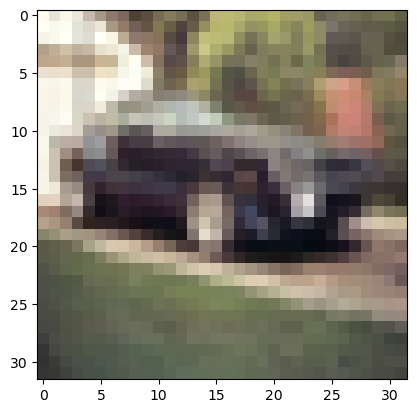

In [49]:
dataiter = iter(testloader)
images, labels = next(dataiter)
index = 0
# Display the images using the imshow function
imshow(torchvision.utils.make_grid(images[index]))
print(f" predicted class: {classes[np.argmax(net.forward(images[index]).detach().numpy())]}")
{i: j for (i, j) in zip(classes ,(list(net.forward(images[index]).detach().numpy())[0]))}

In [ ]:
# Visualization using matplotlib and seaborn
    plt.figure(figsize=(13, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap='viridis', 
                xticklabels=name_of_classes, yticklabels=name_of_classes)

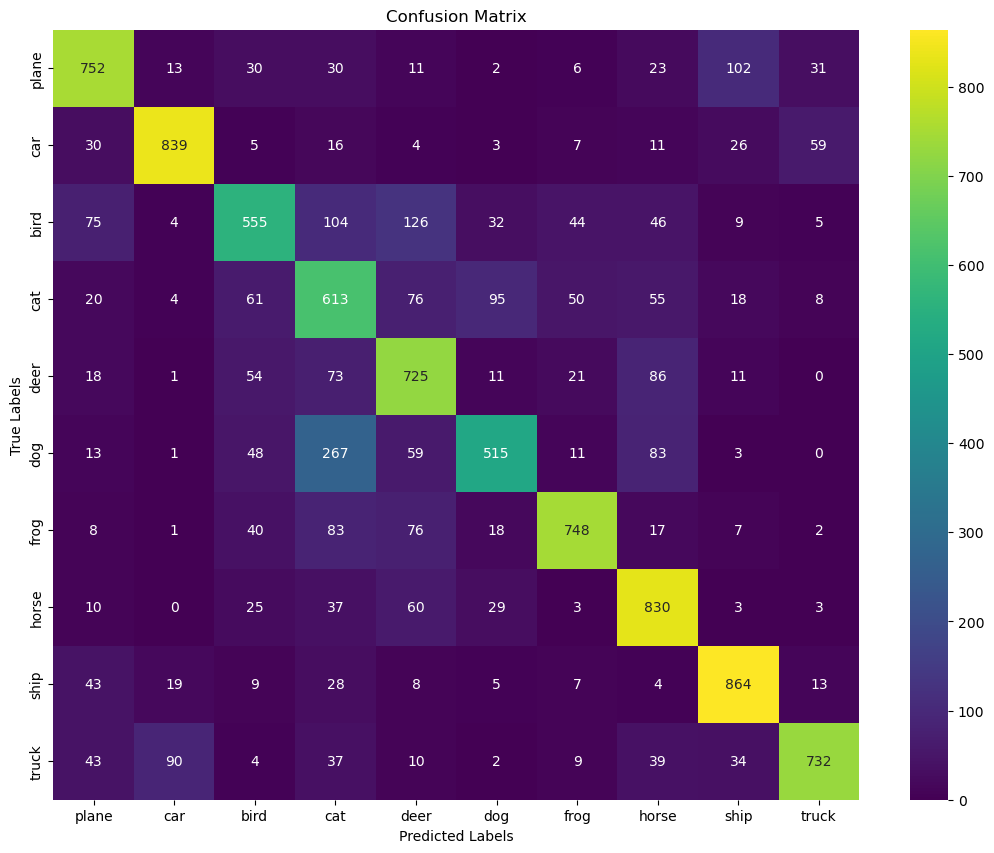

In [19]:
utils.print_confusion_matrix(net, testset, classes)

In [18]:
# load model:
net = Net()
net.load_state_dict(torch.load("74acc_model.pth"))

<All keys matched successfully>

In [ ]:
importlib.reload(utils)

In [ ]:
utils.plot_poly_fit(test_losses,4)
utils.plot_log_fit(running_losses)

In [ ]:
def plot_log_fit(running_losses):
    with torch.no_grad():
        epochs = list(range(len(running_losses)))
        # Prepare x and y data, shift x data to ensure positivity 
        x_data = np.array(epochs) + 1  # +1 to avoid log(0) which is undefined
        y_data = np.array(running_losses)
        # Fit the model
        params, params_covariance = curve_fit(log_model, x_data, y_data, p0=[1, 1, 1])
        # Generate x values for the curve
        x_fit = np.linspace(1, len(running_losses), 400)
        y_fit = log_model(x_fit, *params)
        # Plotting the data
        plt.figure(figsize=(10, 5))
        plt.scatter(epochs, running_losses, label='Individual Losses', alpha=0.6)  # Alpha for better visibility of the trend
        plt.plot(x_fit - 1, y_fit, label='Logarithmic Fit', color='red')  # Plot the fitted curve
        # Add labels, title, and grid
        plt.title('Training Loss with Logarithmic Fit')
        plt.xlabel('Batch Index (x1000)')
        plt.ylabel('Average Loss')
        plt.grid(True)
        plt.legend()  # Show legend
        plt.show()

# fit poly expression
def plot_poly_fit(running_losses, deg):
    with torch.no_grad():   
        plt.figure(figsize=(10, 5))
        
        # Data points
        epochs = list(range(len(running_losses)))
        plt.scatter(epochs, running_losses, label='Individual Losses', alpha=0.6)  # Alpha for better visibility of the trend
    
        # Fit a third-degree (cubic) polynomial
        coeffs = np.polyfit(epochs, running_losses, deg)
        poly = np.poly1d(coeffs)
        
        # Generate x-values for plotting the polynomial line
        x_poly = np.linspace(0, len(running_losses)-1, num=len(running_losses))
        y_poly = poly(x_poly)
        
        plt.plot(x_poly, y_poly, color='red', label='Cubic Polynomial Trend')
    
        # Add labels, title, and grid
        plt.title('Training Loss per 1000 Batches with Cubic Polynomial Trend')
        plt.xlabel('Batch Index (x1000)')
        plt.ylabel('Average Loss')
        plt.grid(True)
        plt.legend() 
        plt.show()